## Деревья решений

#### Задание 1.

В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.).

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=500, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, flip_y=.5, random_state=5)

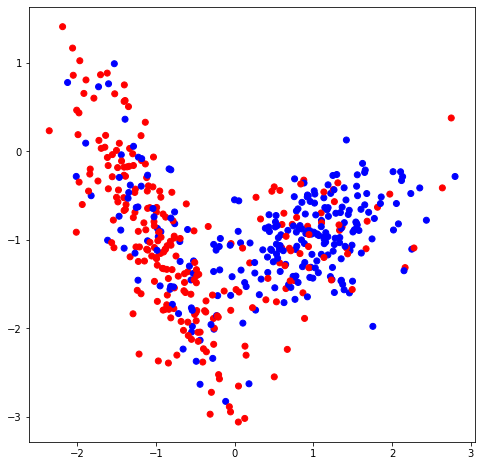

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

**Я реализовал следующие критерии останова:**

- минимальное количество объектов в листе
- максимальная глубина
- максимальное количество листьев

Также есть возможность выбрать критерий Джинни или энтропию Шенонна.

Для удобства использования был создан отдельный класс DTC, в котором публичными методами являются fit(), predict() и print_tree(). Все гиперпараметры являются параметрами экземпляра модели.

Особая сложность была при критерии останова по максимальному количеству листьев. При обычном рекурсивном вызове функций дерево строится "сначала вглубь". Таким образом, ограничивая количество листьев мы можем получить дерево, в котором одна половина глубокая и переобученная, а вторая необученная совсем. Чтобы избежать этого, был написан алгоритм построения дерева "сначала вширь", где узлы дерева строятся по уровням глубины. Из за этого функция build_tree была существенно изменена.

In [6]:
class DTC:
    
    def __init__(self, min_leaf=1, criterion='gini', max_depth=None, max_leaf_count=None):
        self.min_leaf = min_leaf
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_leaf_count = max_leaf_count 
        self._tree = None # дерево решений
        self.tasks = [] # список задач для создания дерева 'сначала вширь'
        self.nodes = [{ # список узлов для создания дерева 'сначала вширь'
            'id_': 0,
            'parent_id': None,
            't': None,
            'index': None,
            'is_left': None,
            'is_node': True
        }]
        self.leaf_count = 0 # счетчик листьев
        
    
    def _criterion(self, labels):
        #  подсчет количества объектов разных классов
        classes = {}
        for label in labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        #  расчет критерия
        if self.criterion == 'gini':
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2
        elif self.criterion == 'shannon':
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                part = p * np.log2(p) if p else 0
                impurity -= part

        return impurity  
    
    
    def _quality(self, left_labels, right_labels, current_criterion):

        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

        return current_criterion - p * self._criterion(left_labels) - (1 - p) * self._criterion(right_labels)

    
    def _split(self, data, labels, index, t):

        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]

        return true_data, false_data, true_labels, false_labels
    
    
    def _find_best_split(self, data, labels):

        current_criterion = self._criterion(labels)

        best_quality = 0
        best_t = None
        best_index = None

        n_features = data.shape[1]

        for index in range(n_features):
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self._quality(true_labels, false_labels, current_criterion)

                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index
    
    
    def _build_tree(self, data, labels, level=0, id_=0):

        quality, t, index = self._find_best_split(data, labels)
        
        # Проверяем, что сумма количества листьев и узлов в списке вместе с текущей задачей меньше self.max_leaf_count:
        if self.max_leaf_count is not None:
            max_leaf_flag = False if self.leaf_count + len(self.tasks) + 1 < self.max_leaf_count else True
        else:
            max_leaf_flag = False

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества или дерево достигло максимальной глубины,
        # или количество листьев больше или равно максимальному
        if quality == 0 or level == self.max_depth or max_leaf_flag:
            self.leaf_count += 1
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['is_node'] = False
                    itm['data'] = data
                    itm['labels'] = labels
            if len(self.tasks):
                self._build_tree(*self.tasks.pop(0))
        else:
            true_data, false_data, true_labels, false_labels = self._split(data, labels, index, t)
            for itm in self.nodes:
                if itm['id_'] == id_:
                    itm['t'] = t
                    itm['index'] = index

            # Добавляем в список задач и список узлов две ветки поддерева
            level += 1
            current_len = len(self.nodes)
            self.tasks.append([true_data, true_labels, level, current_len])
            self.tasks.append([false_data, false_labels, level, current_len + 1])
            self.nodes.append({
                'id_': current_len,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': True,
                'is_node': True
            })
            self.nodes.append({
                'id_': current_len + 1,
                'parent_id': id_,
                't': None,
                'index': None,
                'is_left': False,
                'is_node': True
            })


            self._build_tree(*self.tasks.pop(0))

    
    def _create_instance(self, id_=0): # функция создания дерева по списку узлов self.nodes
        for itm in self.nodes:
            if itm['id_'] == id_:
                if itm['is_node']:
                    index = itm['index']
                    t = itm['t']
                    break
                else:
                    return Leaf(itm['data'], itm['labels'])
        for itm in self.nodes:
            if itm['parent_id'] == id_ and itm['is_left']:
                true_branch = self._create_instance(itm['id_'])
            if itm['parent_id'] == id_ and not itm['is_left']:
                false_branch = self._create_instance(itm['id_'])
        
        return Node(index, t, true_branch, false_branch)
    
    
    def fit(self, data, labels):
        self._build_tree(data, labels, 0, 0)
        self._tree = self._create_instance()
        
        
    def _classify_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self._classify_object(obj, node.true_branch)
        else:
            return self._classify_object(obj, node.false_branch)
    
    
    def predict(self, data):

        classes = []
        for obj in data:
            prediction = self._classify_object(obj, self._tree)
            classes.append(prediction)
        return classes
    
    
    def print_tree(self):
        node = self._tree
        self._print_nodes(node)
    
    
    def _print_nodes(self, node, spacing=""):

        # Если лист, то выводим его прогноз
        if isinstance(node, Leaf):
            print(spacing + "Прогноз:", node.prediction)
            return

        # Выведем значение индекса и порога на этом узле
        print(spacing + 'Индекс', str(node.index))
        print(spacing + 'Порог', str(node.t))

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> True:')
        self._print_nodes(node.true_branch, spacing + "  ")

        # Рекурсионный вызов функции на положительном поддереве
        print (spacing + '--> False:')
        self._print_nodes(node.false_branch, spacing + "  ")

        

In [7]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [8]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

*Обучим дерево классификации сначала без параметров. Как видно, такое дерево получилось очень глубоким:*

In [9]:
dtc = DTC(
#     min_leaf=5, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3
)
dtc.fit(train_data, train_labels)
train_answers = dtc.predict(train_data)
answers = dtc.predict(test_data)

In [11]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers):
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, answers)
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(dtc.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    plt.show()

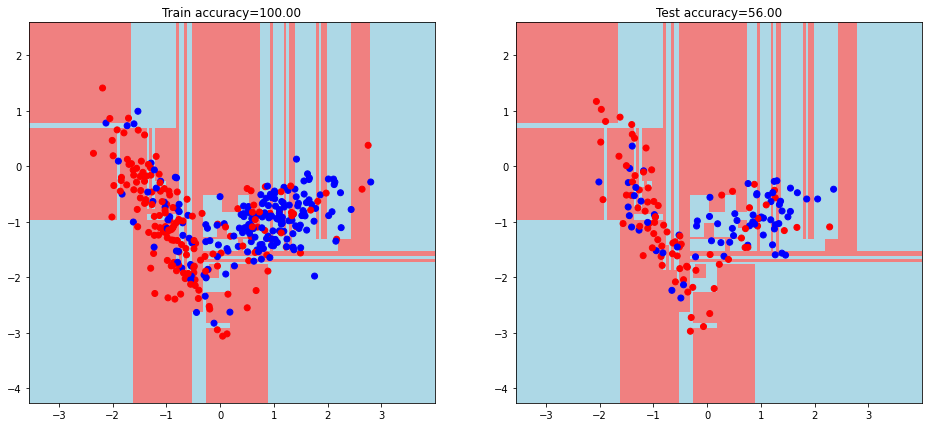

In [12]:
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

#### Задание 2.

Для задачи классификации обучить дерево решений с использованием критериев разбиения Джини и Энтропия. Сравнить качество классификации, сделать выводы.

*Обучим дерево без гиперпараметров, но с энтропией Шеннона:*

In [13]:
dtc = DTC(
#     min_leaf=5, 
    criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3
)
dtc.fit(train_data, train_labels)
train_answers = dtc.predict(train_data)
answers = dtc.predict(test_data)

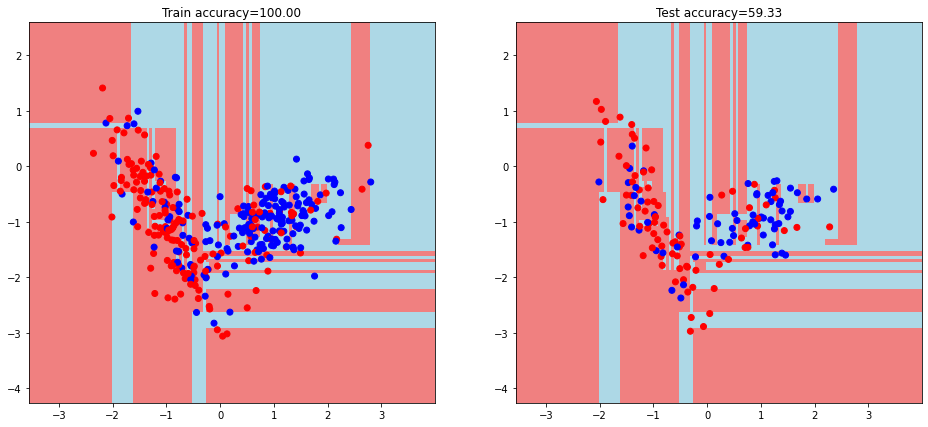

In [14]:
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

*Как видим, при энтропии Шеннона и критерии Джинни разделяющие плоскости отличаются. Но при этом Accuracy на тестовой выборке различаются не сильно, хотя в данном случае при энтропии качество на 3% выше. Вообще, графики функций критерия Джинни и энтропии Шеннона довольно схожи, поэтому выбор того или иного критерия редко дает серьезный прирост качества. Такое утверждение я встречал и в статьях про ML.*

In [15]:
def draw_hypreparameters(train_accuracy, test_accuracy, xlabel, ylabel):
    plt.figure(figsize = (16, 7))
    plt.plot(range(1, len(train_accuracy)+1), train_accuracy, label='train')
    plt.plot(range(1, len(train_accuracy)+1), test_accuracy, label='test')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

*Далее представим графики зависимости метрики качества модели от гиперпараметров на тестовой тренировочной выборках:*

In [16]:
train_accuracy = []
test_accuracy = []
for itm in range(1, 61):
    dtc = DTC(min_leaf=itm)
    dtc.fit(train_data, train_labels)
    train_answers = dtc.predict(train_data)
    answers = dtc.predict(test_data)
    train_accuracy.append(accuracy_metric(train_labels, train_answers))
    test_accuracy.append(accuracy_metric(test_labels, answers))

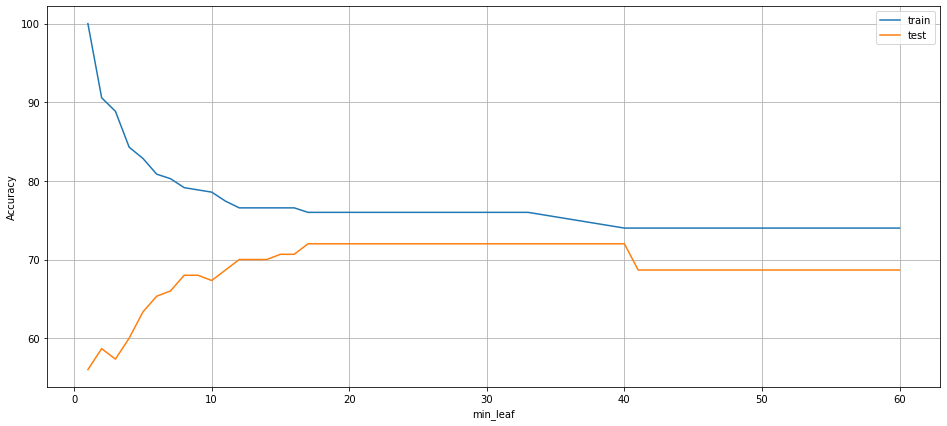

In [17]:
draw_hypreparameters(train_accuracy, test_accuracy, 'min_leaf', 'Accuracy')

In [18]:
train_accuracy = []
test_accuracy = []
for itm in range(1, 20):
    dtc = DTC(max_depth=itm)
    dtc.fit(train_data, train_labels)
    train_answers = dtc.predict(train_data)
    answers = dtc.predict(test_data)
    train_accuracy.append(accuracy_metric(train_labels, train_answers))
    test_accuracy.append(accuracy_metric(test_labels, answers))

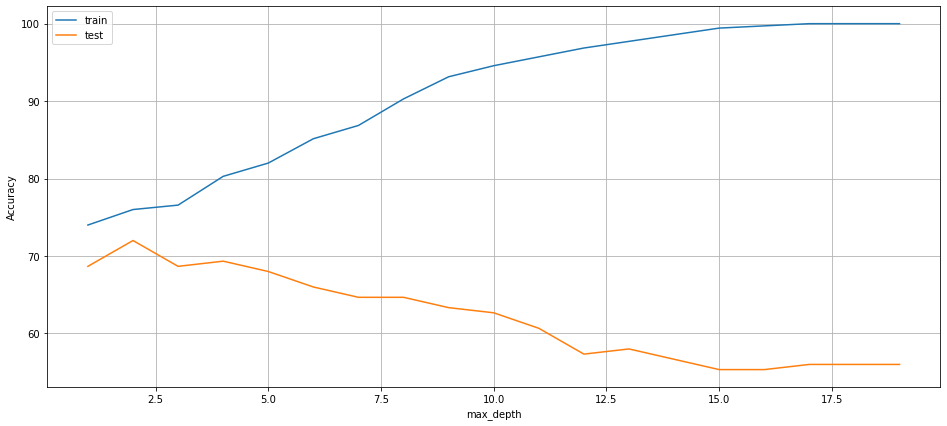

In [19]:
draw_hypreparameters(train_accuracy, test_accuracy, 'max_depth', 'Accuracy')

In [20]:
train_accuracy = []
test_accuracy = []
for itm in range(1, 101):
    dtc = DTC(max_leaf_count=itm)
    dtc.fit(train_data, train_labels)
    train_answers = dtc.predict(train_data)
    answers = dtc.predict(test_data)
    train_accuracy.append(accuracy_metric(train_labels, train_answers))
    test_accuracy.append(accuracy_metric(test_labels, answers))

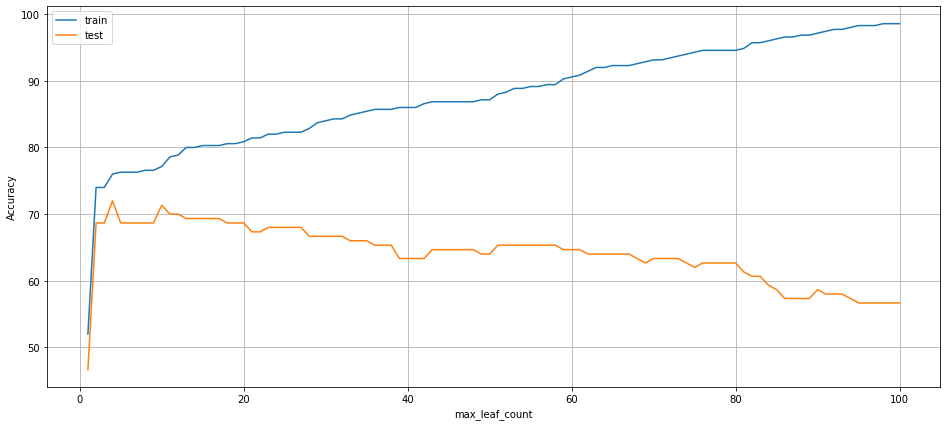

In [21]:
draw_hypreparameters(train_accuracy, test_accuracy, 'max_leaf_count', 'Accuracy')

*По представленным графикам можно сделать вывод, что наиболее оправданным для этих данных является изменение минимального количества наблюдений в листе. При изменении этого гиперпараметра метрика качества плавно улучшается, без резких скачков. Потом на отрезке min_leaf=[17..33] на трейне и тесте метрика качества ведет себя стабильно и не меняется.*

*Для финальной модели выберем гиперпараметр min_leaf=17:*

In [22]:
dtc = DTC(
    min_leaf=17, 
#     criterion='shannon', 
#     max_depth=4,
#     max_leaf_count=3
)
dtc.fit(train_data, train_labels)
train_answers = dtc.predict(train_data)
answers = dtc.predict(test_data)

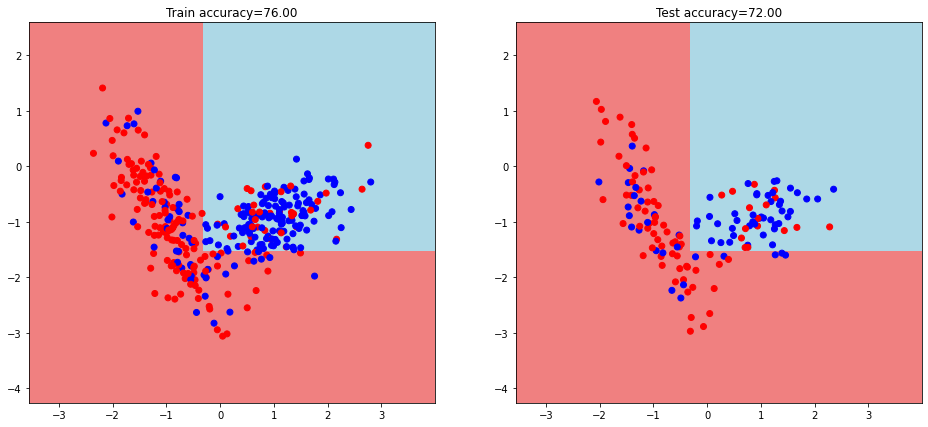

In [23]:
draw_separating_plane(train_data, test_data, train_labels, test_labels, train_answers, answers)

*Модель получилась простой и достаточно надежной: метрика трейне и тесте различаются незначительно.*

#### Задание 3.

Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

*Для реализации класса DTR унаследуем класс DTC и переопределим методы расчета критерия информативности и создания дерева. Также создадим новый класс для листа, унаследованный от листа из классификации, и переопределим метод расчета предсказаний в нем:*

In [24]:
class Leaf_regr(Leaf):
    
    def __init__(self, *args): # оставил labels, а не target, чтобы не переписывать весь класс из-за одной переменной
        super().__init__(*args)
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)

In [25]:
class DTR(DTC):
    
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.criterion = None
        
    
    def _criterion(self, labels):

        return labels.var()
    
    
    def _create_instance(self, id_=0): # функция создания дерева по списку узлов self.nodes
        for itm in self.nodes:
            if itm['id_'] == id_:
                if itm['is_node']:
                    index = itm['index']
                    t = itm['t']
                    break
                else:
                    return Leaf_regr(itm['data'], itm['labels'])
        for itm in self.nodes:
            if itm['parent_id'] == id_ and itm['is_left']:
                true_branch = self._create_instance(itm['id_'])
            if itm['parent_id'] == id_ and not itm['is_left']:
                false_branch = self._create_instance(itm['id_'])
        
        return Node(index, t, true_branch, false_branch)

    

*Для задачи регрессии возьмем нелинейную функцию из прошлых методичек, и добавим в целевую переменную шум:*

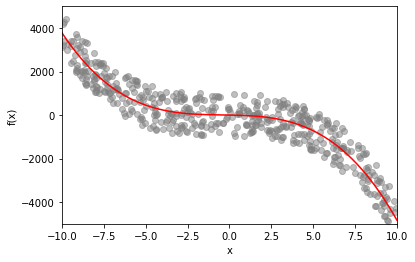

In [26]:
def f(x):
    return 0.6 - 13.2 * x - 5.3 * x ** 2 - 4.17 * x ** 3

np.random.seed(16)
x_data = np.random.uniform(-10, 10, 500)
f_data = [f(i) for i in x_data] + np.random.uniform(-1000, 1000, 500)

dots = np.linspace(-10, 10, 1000)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(-5000, 5000)
plt.xlim(-10,10)

plt.plot(dots, f(dots), color='r')
plt.scatter(x_data, f_data, color='grey', alpha=0.5)
plt.show()

In [27]:
x_data = x_data.reshape((500, 1))
train_data, test_data, train_target, test_target = model_selection.train_test_split(x_data, 
                                                                                     f_data, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [28]:
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

*Сначала обучим дерево регрессии без гиперпараметров:*

In [29]:
dtr = DTR(
#     min_leaf = 13,
#     max_depth = 4,
#     max_leaf_count = 13
)
dtr.fit(train_data, train_target)
train_answers = dtr.predict(train_data)
answers = dtr.predict(test_data)

In [33]:
def draw_dtr(train_target, train_answers, test_target, answers, dots):
    plt.figure(figsize = (16, 7))
    train_mse = calc_mse(train_target, train_answers)
    test_mse = calc_mse(test_target, answers)
    dots = dots.reshape((-1, 1))
    y = dtr.predict(dots)

    plt.subplot(121)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.ylim(-5000, 5000)
    plt.xlim(-10,10)
    plt.title(f'Train, MSE={train_mse}')

    plt.plot(dots, f(dots), color='r')
    plt.scatter(train_data, train_target, color='grey', alpha=0.5)
    plt.plot(dots, y)

    plt.subplot(122)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.ylim(-5000, 5000)
    plt.xlim(-10,10)
    plt.title(f'Test, MSE={test_mse}')

    plt.plot(dots, f(dots), color='r')
    plt.scatter(test_data, test_target, color='grey', alpha=0.5)
    plt.plot(dots, y)

    plt.show()

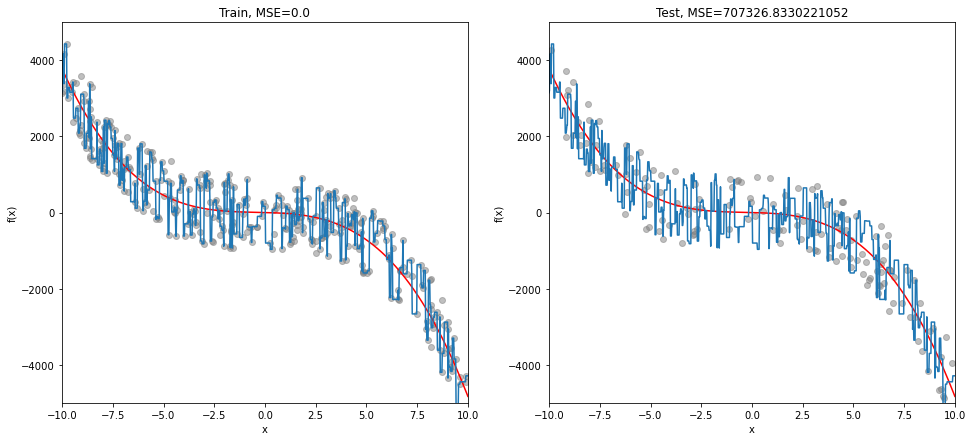

In [34]:
draw_dtr(train_target, train_answers, test_target, answers, dots)

*Видно, что без гиперпараметров на тренировочной выборке дерево переобучилось и полностью подстроилось под тренировочную выборку. При этом с тестовой выборкой такие предсказания имеют мало что общего.*

*Также проведем исследования влияния гиперпараметров на метрику:*

In [35]:
train_mse = []
test_mse = []
for itm in range(1, 101):
    dtr = DTR(min_leaf=itm)
    dtr.fit(train_data, train_target)
    train_answers = dtr.predict(train_data)
    answers = dtr.predict(test_data)
    train_mse.append(calc_mse(train_target, train_answers))
    test_mse.append(calc_mse(test_target, answers))

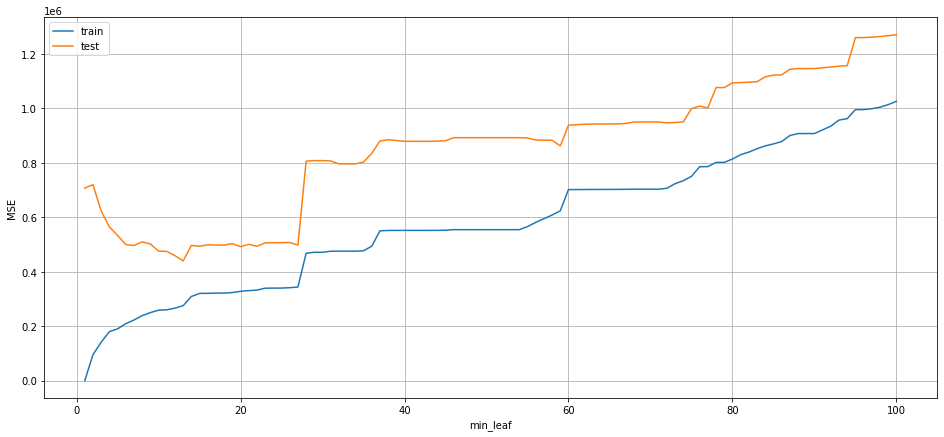

In [36]:
draw_hypreparameters(train_mse, test_mse, 'min_leaf', 'MSE')

In [37]:
train_mse = []
test_mse = []
for itm in range(1, 21):
    dtr = DTR(max_depth=itm)
    dtr.fit(train_data, train_target)
    train_answers = dtr.predict(train_data)
    answers = dtr.predict(test_data)
    train_mse.append(calc_mse(train_target, train_answers))
    test_mse.append(calc_mse(test_target, answers))

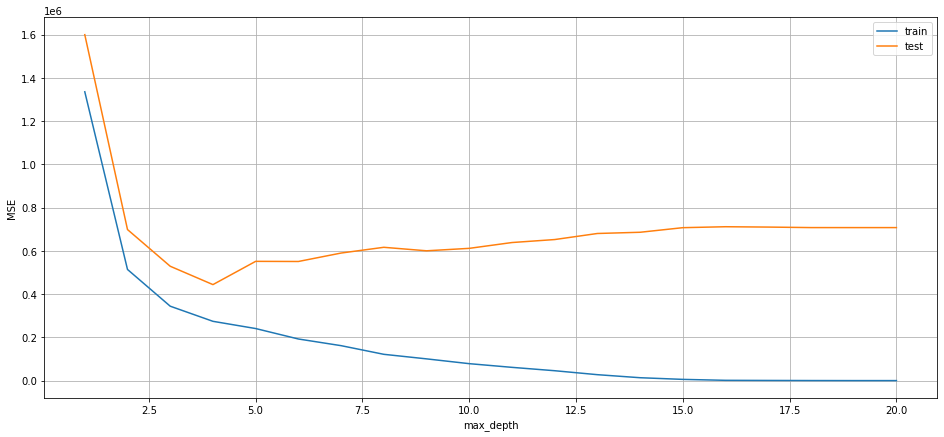

In [38]:
draw_hypreparameters(train_mse, test_mse, 'max_depth', 'MSE')

In [39]:
train_mse = []
test_mse = []
for itm in range(1, 101):
    dtr = DTR(max_leaf_count=itm)
    dtr.fit(train_data, train_target)
    train_answers = dtr.predict(train_data)
    answers = dtr.predict(test_data)
    train_mse.append(calc_mse(train_target, train_answers))
    test_mse.append(calc_mse(test_target, answers))

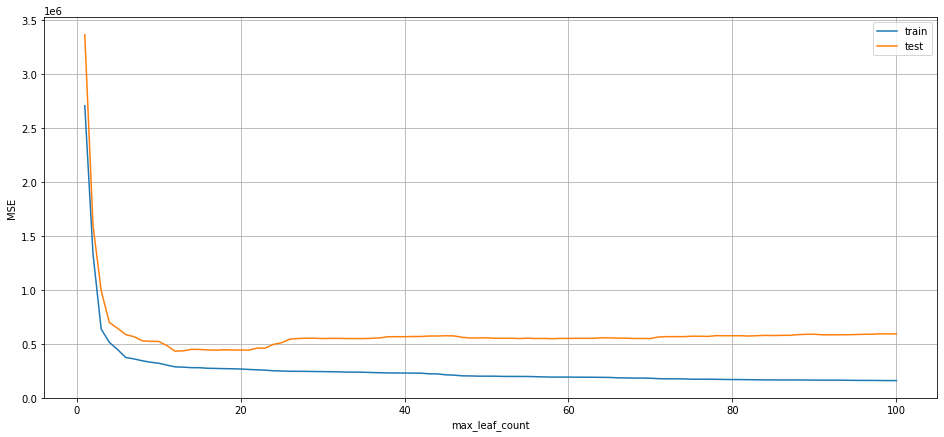

In [40]:
draw_hypreparameters(train_mse, test_mse, 'max_leaf_count', 'MSE')

*Наиболее гладкой с ярко выраженным минимумом выглядит функция зависимости глубины дерева от среднеквадратичной ошибки. Минимум наблюдается при глубине 4. Построим такую модель:*

In [41]:
dtr = DTR(
#     min_leaf=13, 
    max_depth=4,
#     max_leaf_count=13
)
dtr.fit(train_data, train_target)
train_answers = dtr.predict(train_data)
answers = dtr.predict(test_data)

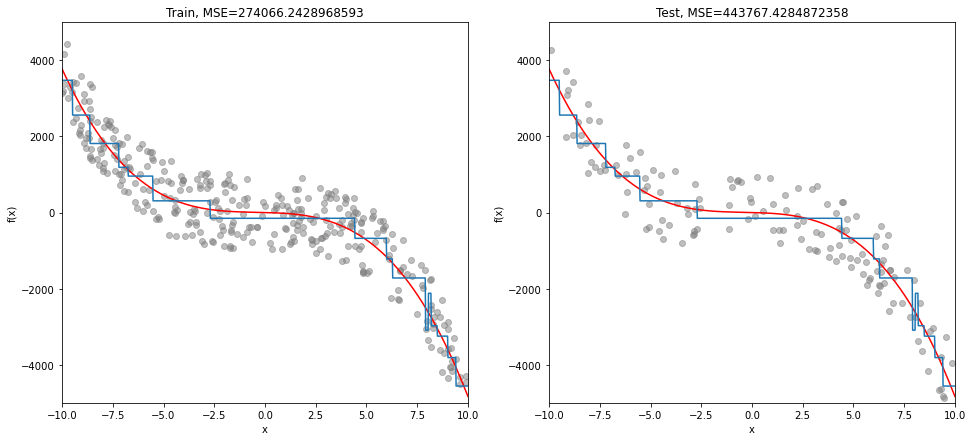

In [42]:
draw_dtr(train_target, train_answers, test_target, answers, dots)

*Как видно, алгоритм неплохо приближает исходную зависимость, но в конце графика виден переобученный участок. Применим остальные гиперпараметры модели, при которых ошибка была минимальна:*

In [43]:
dtr = DTR(
    min_leaf=13, 
    max_depth=4,
    max_leaf_count=13
)
dtr.fit(train_data, train_target)
train_answers = dtr.predict(train_data)
answers = dtr.predict(test_data)

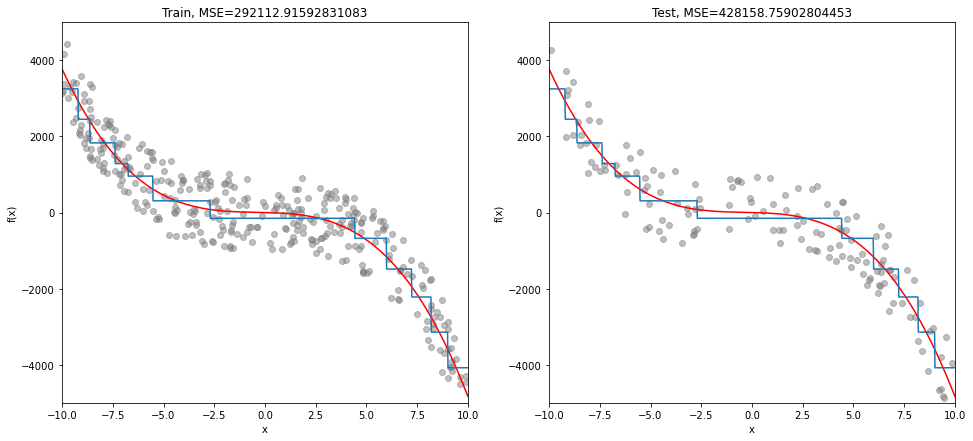

In [44]:
draw_dtr(train_target, train_answers, test_target, answers, dots)

*Ошибка на тесте немного уменьшилась, и теперь алгоритм более плавно приближает исходную зависимость. Такой подход к подбору параметров достаточно наивен, правильно использовать поиск по сетке с кросс-валидацией.*